In [1]:
"""
Web scraping price information from www.mediamarkt.es
Based on:
https://github.com/Brinkhuis/Mediamarkt/blob/master/code/mediamarkt.py
"""

import ast
import requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time

from bs4 import BeautifulSoup
from tqdm import tqdm

%matplotlib inline

In [2]:
URL = "https://www.mediamarkt.es/es/category/_afeitadoras-faciales-701281.html"
#URL = 'http://www.mediamarkt.nl/nl/category/_laptops-482723.html'

In [3]:
def npages(mysoup):
    pagination = list()
    for page_number in mysoup.find_all('div', {'class': 'pagination-wrapper cf'}):
        pagination.append(page_number.find_all('a'))
    return int(str(pagination[0]).split(', ')[-2].strip('</a>').split('>')[-1])


def get_data(output_file = None):
    item_list = list()
    for page in tqdm(range(1, npages(BeautifulSoup(requests.get(URL).text, 'html.parser')) + 1)):
        soup = BeautifulSoup(requests.get(URL + '?page=' + str(page)).text, 'html.parser')
        all_scripts = soup.find_all('script')
        for script in all_scripts:
            if script.text.startswith('var product'):
                item_list.append(ast.literal_eval(script.text.split(' = ')[1].strip(';')))

    productinfo = pd.DataFrame(item_list)
    
    productinfo['price'] = pd.to_numeric(productinfo['price'], errors='coerce')
    
    productinfo.to_csv(output_file, index=False)
    
    print(f'{productinfo.shape[0]} records saved to {output_file}')
    
    return productinfo

In [4]:
#pro_info = get_data()

In [5]:
#output_file = './belleza_y_salud.csv'
#pro_info.to_csv(output_file)

In [6]:
#print(f'{pro_info.shape[0]} records saved to {output_file}')

In [7]:
def viz_data(input_file, output_file):
    productinfo = pd.read_csv(input_file)

    x_pixels, y_pixels, dpi = 1500, 1000, 150
    x_inch, y_inch = x_pixels / dpi, y_pixels / dpi

    plt.figure(figsize=(x_inch, y_inch), dpi=dpi)
    sns.boxplot(x='price',
                y='brand',
                data=productinfo.groupby('brand').filter(lambda x: len(x) > 3),
                order=list(productinfo.groupby('brand').filter(lambda x: len(x) > 3)
                           .groupby('brand').price.median().sort_values(ascending=False).index),
                palette='PRGn',
                width=0.75).set_title('Price Distribution per Brand')
    sns.despine(offset=10, trim=True)
    plt.savefig(output_file)
    plt.show()
    plt.close()
    
    print(f'Visualization saved to {output_file}')


def main():
    dat = './data/productinfo.csv'
    viz = './plots/price_distribution_brand.png'
    
    get_data(dat)
    time.sleep(2)
    viz_data(dat, viz)

100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


47 records saved to ./data/productinfo.csv


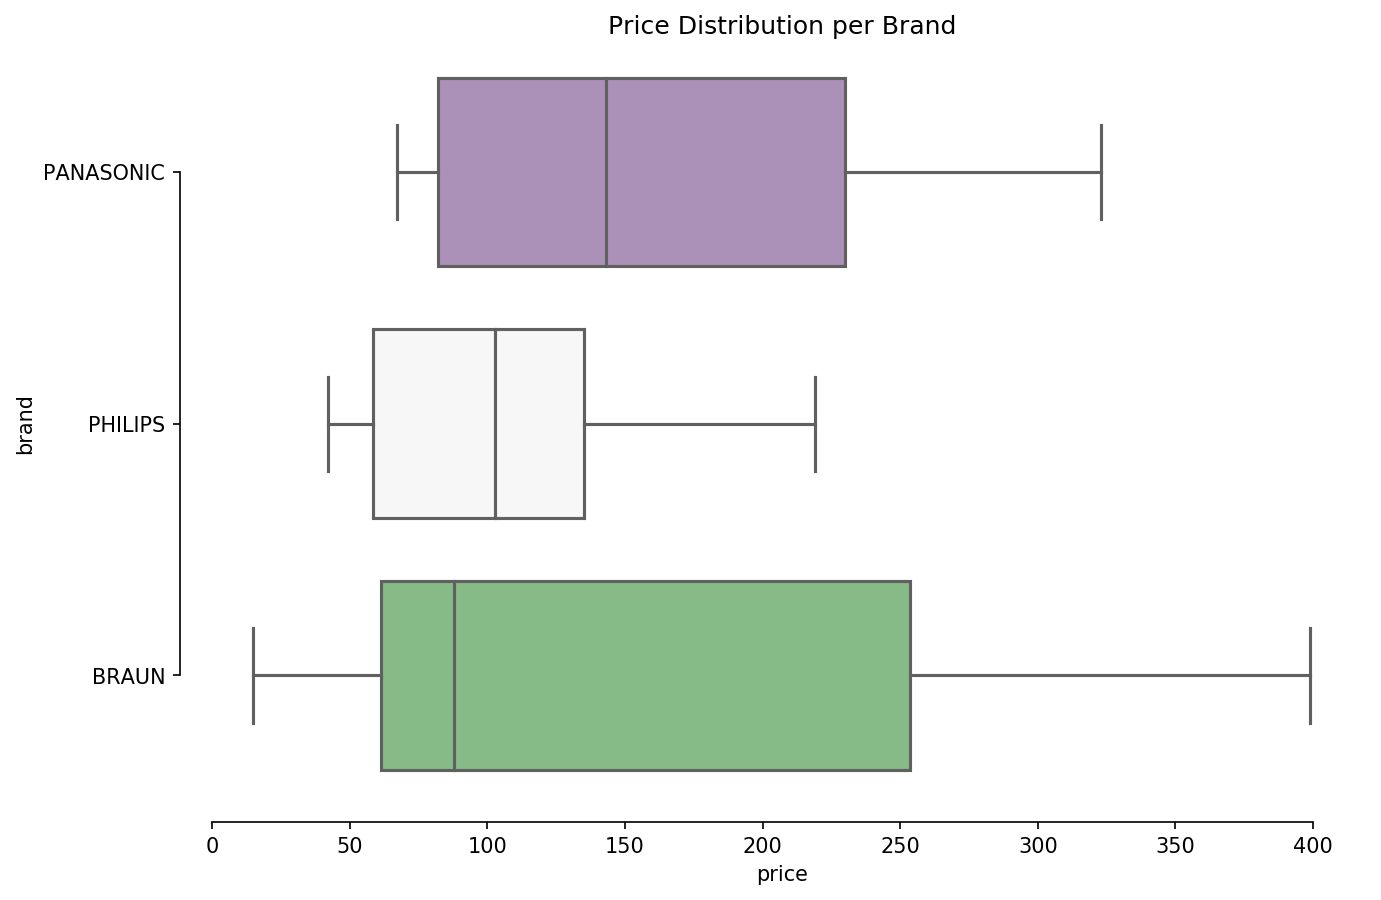

Visualization saved to ./plots/price_distribution_brand.png


In [8]:
if __name__ == "__main__":
    main()